# はじめに
ドルコスト平均法をpython, pandasを使ってシミュレートします。
読者はpython, pandasの基礎的な知識を持っているものとします。

![pngfile](./randomwalk_files/randomwalk_6_1.png)
![pngfile](./randomwalk_files/randomwalk_33_2.png)

概要こんな感じ。
あとで使う画像です。

ここでは株価や為替の既存のチャートを使用しません。
トレンド相場、レンジ相場の様々な形の相場でドルコスト平均法を試したいのですが、
既存のチャートでトレンドやレンジを調べて切り出してくることに労力がかかるためです。

そこで、ランダムに生成させた仮のチャートを使用します。
見た目がチャートにそっくりなので、これでもざっくりシミュレーションには有効でしょう。
その動きに対してドルコスト平均法を適用して、この投資法の有効性を判定する目論見です。

# 金融用語説明
プログラムするにはルールを知らなければいけませんので記載します。
リンク先はwikipediaです。

## [ドルコスト平均法](https://ja.wikipedia.org/wiki/%E3%83%89%E3%83%AB%E3%83%BB%E3%82%B3%E3%82%B9%E3%83%88%E5%B9%B3%E5%9D%87%E6%B3%95)

* 投資手法の一つで、高値掴みを避けるように投資額を時間的に分割して均等額ずつ定期的に投資します。
* 重要なのが投資額を等分する際、**金額分割**を行うこと
    * 単純な数量分割に比べ平均値の点で有利になると言われています。
    * ○金額分割: 定額数の株や、変量数の売通貨で定額の買通貨を購入すること
        * 1000,000円投資を10回に分けて100,000円分ずつの株を購入すること
        * 1000ドル投資を10回に分けて、100ドル分ずつのドルを購入すること
    * ×数量分割: 定量数の株や、定額の売通貨で買通貨を購入すること
        * 1000株投資を10回に分けて100株ずつ購入すること
        * 100,000円投資を10回に分けて10,000円分ずつのドルを購入すること

### ドルコスト平均法のルール
1. 一定数ではなく、一定額を買うようにします。
    * 値段が下がればいっぱい買えます。
    * 値段が上がれば控えめに買っておきます。
1. 定期的に購入します。
	* 僕の使っている手法として、週の最安値(だと思っているところ)で指値をいれます。


## [ランダムウォーク](https://ja.wikipedia.org/wiki/%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%83%BB%E3%82%A6%E3%82%A9%E3%83%BC%E3%82%AF%E7%90%86%E8%AB%96)
* 現れる位置が確率的に無作為（ランダム）に決定される運動のことです。
* 株価や為替の価格は誰かが買うと上がり、売ると下がります。
	* つまり上がるか下がるかの2択
* 長期的に見ても短期的(ある程度の限度はあるが)に見ても似たような形が出現する、
自己相似形([フラクタル](https://ja.wikipedia.org/wiki/%E3%83%95%E3%83%A9%E3%82%AF%E3%82%BF%E3%83%AB#.E3.83.95.E3.83.A9.E3.82.AF.E3.82.BF.E3.83.AB.E3.81.AE.E4.BE.8B))
の形状をしています。

### ランダムウォークのpandas Seriesを作成

   bullbear  price
0         1      1
1         1      2
2        -1      1
3        -1      0
4         0      0


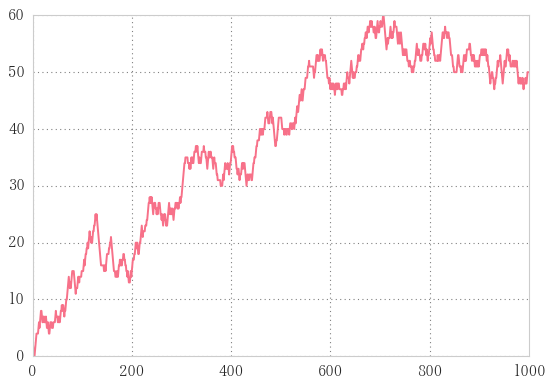

In [7]:
n = 1000
bullbear = pd.Series(np.random.randint(-1, 2, n))  # -1,0,1のどれかを生成するpd.Series
price = bullbear.cumsum()  # 累積和

print(pd.DataFrame({'bullbear': bullbear, 'price': price}).head())
price.plot()

## ランダムウォークの関数化

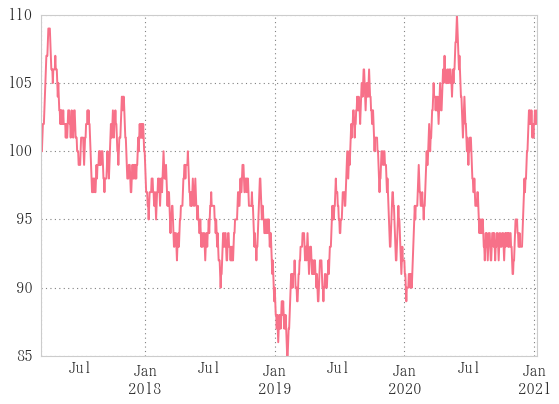

In [5]:
def randomwalk(periods, start=pd.datetime.today().date(), name=None):
    """periods日分だけランダムウォークを返す"""
    ts = pd.date_range(start=start, periods=periods, freq='B')  # 今日の日付からperiod日分の平日
    bullbear = pd.Series(np.random.randint(-1, 2, periods),
                         index=ts, name=name)  # -1,0,1のどれかを吐き出すSeries
    price = bullbear.cumsum()  # 累積和
    return price
price=randomwalk(periods=1000) + 100  # 100は初期値
price.plot()

一日ごとに

* 1円上がる
* 1円下がる
* 動かない(0円動く)

を模擬したチャートができました。

初期値を100円、期間を1000日とすることで、100円から始まる約3年分の仮想ドル円チャートです。

一日1円とか、このチャートがドル円だとすると2016年の上海ショック、ブレグジットショック、米大統領選が毎日続いているかのようなお祭りボラティリティですね。

# 定期的に購入
ドルコスト平均法の(2)

毎週毎週購入かけているとお金が大量に必要になってしまう。
そんなに大量のお給料をもらっていないのである程度制限する。
ある週に1回でも購入したら、その週は条件が来ても購入を控えようと思う。

仮に、理想的に毎週の底値で購入できたとする

In [59]:
lowweek = price.resample('W').min()
lowweek[:10]

2017-03-19    98
2017-03-26    97
2017-04-02    98
2017-04-09    98
2017-04-16    97
2017-04-23    93
2017-04-30    92
2017-05-07    93
2017-05-14    93
2017-05-21    91
Freq: W-SUN, dtype: int32

## ticket, cost, assetの計算関数

In [87]:
def profitcalc(price, unit_cost): 
    """購入した価格からプロフィットカーブを計算する
        引数:
            price: 購入価格と日付のSeries
            unit_cost: 購入一定額
        戻り値: price, tickets, cost, asset, profitを入れたdataframe"""
    tickets = dollcost(price, unit_cost)  # dollcost関数: 一定額ずつの購入
    cost = tickets * price
    asset = cost.cumsum()
    profit = tickets.cumsum() * price - asset
    df = pd.DataFrame([price, tickets, cost, asset, profit],
            index=['price', 'tickets', 'cost', 'asset', 'profit']).T
    print('Final Asset: %d'% df.asset[-1])
    print('Final Profit: %d'% df.profit[-1])
    return df

# 一定金額を買い
ドルコスト平均法の(1)

## 購入口数(ticket)の決定

* 価格の単位は[円]であるとする
* 購入額(unit_cost)を最大10000円として買っていくとする
* ~~購入口数(ticket)の最小口数(min_cost)は1000円~~ 未実装
* unit_costをある時点での価格(price)で割って、少数切り落とした値が購入口数

In [46]:
unit_cost = 10000
# min_cost = 1000
ticket = unit_cost / price[0]
ticket, int(ticket)

(101.01010101010101, 101)

インデックス0の期間

全期間に適用。

切り捨てすると時は`astype(int)`メソッドを使う。

In [38]:
tickets = unit_cost / price
pd.DataFrame([price, tickets, tickets.astype(int)],
             index=['price', 'ticket(float)', 'ticket(int)']).T.head()

,price,ticket(float),ticket(int)
2017-03-13,99.0,101.010101,101.0
2017-03-14,99.0,101.010101,101.0
2017-03-15,98.0,102.040816,102.0
2017-03-16,98.0,102.040816,102.0
2017-03-17,98.0,102.040816,102.0


## 一定額ずつ購入していったあとの資産の計算

In [55]:
def dollcost(lowprice, unit_cost):
    """一定額ずつの購入
    引数: 
        price: 購入したときの価格と日付のSeries
        unit_cost: 購入するときの一定金額
    戻り値:
        tickets: 購入したチケット数
    """
    tickets = unit_cost / lowprice
    return tickets.astype(int)

            price  tickets    cost   asset  profit
2017-03-13   99.0      NaN     NaN     NaN     NaN
2017-03-14   99.0      NaN     NaN     NaN     NaN
2017-03-15   98.0    102.0  9996.0  9996.0     0.0
2017-03-16   98.0      NaN     NaN     NaN     NaN
2017-03-17   98.0      NaN     NaN     NaN     NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DC634630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DDB44860>], dtype=object)

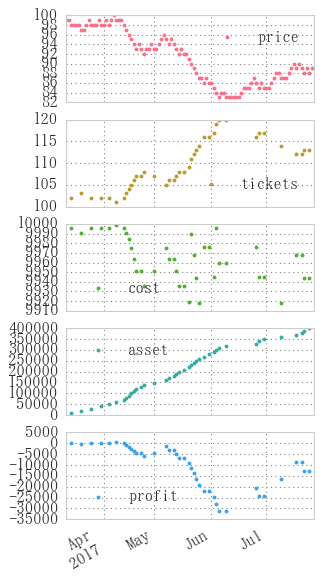

In [56]:
# lowprice関数: 前日より価格が低い時に買いを行った時の時間と価格のSeries返す
# dollcost関数: 一定額ずつの購入
tickets = dollcost(lowprice(price), 10000)
cost = tickets * price
asset = cost.cumsum()
profit = tickets.cumsum() * price - asset

df = pd.DataFrame([price, tickets, cost, asset, profit],
                  index=['price', 'tickets', 'cost', 'asset', 'profit']).T
print(df.head())
df.plot(style='.', subplots=True, figsize=(4,9))

In [57]:
price[-1] * tickets.sum() - cost.sum()  # 最終損益

-8561.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DDCED908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DF0D04A8>], dtype=object)

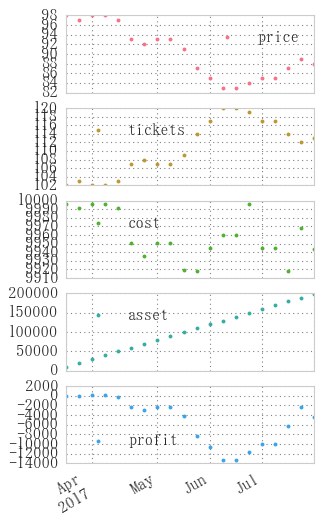

In [64]:
df = profitcalc(lowweek, 10000)
df.head(10)
df.plot(subplots=True, style='.', figsize=[4,8])

In [66]:
df.profit[-1]  # 最終損益

-4433

## 別のランダムウォークで計算

Final Asset: 1993341
Final Profit: -609801


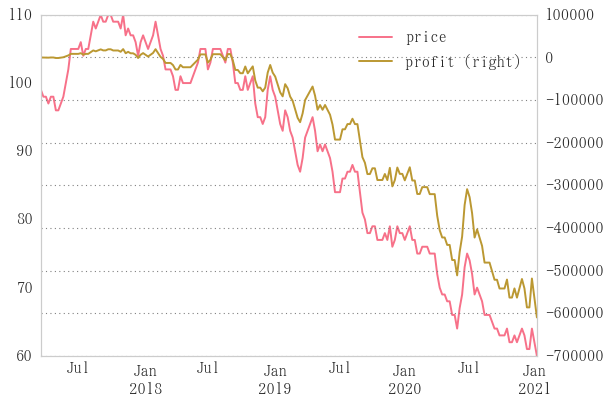

In [99]:
pr = randomwalk(1000) + 100
df = profitcalc(pr.resample('W').min(), unit_cost=10000)
# df.plot(subplots=True, style='.', figsize=[4,8])
df.ix[:, ['price', 'profit']].plot(secondary_y=['profit'], style='.')